# Fine-tuning BioBERT model

## Package imports

In [3]:
import os
import glob
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import BertTokenizer, BertConfig, BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, roc_auc_score

/home/sakshisingh33/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-26 17:22:00.390688: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-26 17:22:00.597371: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748305320.682903   96205 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748305320.705816   96205 cuda_blas.cc:1407] Una

## Data preparation

In [4]:
report_dir = "../download_data/textData/"
labels_file = "../download_data/metadata/edema+pleural_effusion_samples_v2.csv"
model_name = 'dmis-lab/biobert-base-cased-v1.1'
max_length = 128
tokenizer = BertTokenizer.from_pretrained(model_name)
class ReportDataset(Dataset):
    """
    Dataset for radiology reports stored as .txt files.
    Expects directory structure:
      /path/
          s<study_id>/report.txt
          ...
    And a labels file (CSV) with columns: study_id, edema, effusion
    """
    def __init__(self, report_dir, labels_file, tokenizer, max_length=512):
        import pandas as pd
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.reports = []
        self.labels = []
        # print(f"Loading reports from {report_dir} and labels from {labels_file}")

        df = pd.read_csv(labels_file)
        print(df)
        df['study_id'] = df['study_id'].astype(str)
        label_map = df.set_index('study_id')[['edema', 'effusion']].to_dict(orient='index')
        
        case_dirs = glob.glob(os.path.join(report_dir, '*/'))
       
        

        for case_dir in glob.glob(os.path.join(report_dir, '*/')):
            
            report_path = os.path.join(case_dir, 'report.txt')
            if not os.path.exists(report_path):
                print(f"Warning: Report file {report_path} does not exist, skipping.")
                continue
            
            case_name = os.path.basename(os.path.normpath(case_dir))
            
            study_id = case_name[1:]  # Remove the 's' prefix
            

            if study_id in label_map and os.path.exists(report_path):
                with open(report_path, 'r', encoding='utf-8') as f:
                    text = f.read().strip()
                self.reports.append(text)
                # Convert edema/effusion dict to list of 2 numbers
                labels = [label_map[study_id]['edema'], label_map[study_id]['effusion']]
                self.labels.append(labels)

    def __len__(self):
        return len(self.reports)

    def __getitem__(self, idx):
        text = self.reports[idx]
        labels = self.labels[idx]  # 2-element list [edema, effusion]

        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float32)  # multi-label → float32 (for BCEWithLogitsLoss)
        return item
dataset = ReportDataset(report_dir, labels_file, tokenizer, max_length)
print(len(dataset)) 

/home/sakshisingh33/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


      subject_id  study_id  edema  effusion
0       10068880  59302019      0         0
1       10095570  53351393      0         0
2       10119992  55836834      0         0
3       10124346  53643077      0         0
4       10150279  58104553      0         1
...          ...       ...    ...       ...
4995    19470900  51190081      1         1
4996    19275656  57501213      1         1
4997    17513800  52812616      1         1
4998    13506966  58911390      0         0
4999    11861017  53980574      1         1

[5000 rows x 4 columns]
5000


## Compute Metrics

In [5]:
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
    average_precision_score
)

def compute_metrics(y_true, y_pred, y_probs):
    """
    y_true: true binary labels, shape (n_samples, n_labels)
    y_pred: predicted binary labels, shape (n_samples, n_labels)
    y_probs: predicted probabilities, shape (n_samples, n_labels)
    """
    metrics = {}
    for i, name in enumerate(['edema', 'effusion']):
        # Basic metrics
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_true[:, i], y_pred[:, i], average='binary', zero_division=0
        )
        acc = accuracy_score(y_true[:, i], y_pred[:, i])

        # AUROC
        try:
            auroc = roc_auc_score(y_true[:, i], y_probs[:, i])
        except ValueError:
            auroc = float('nan')  # if only one class present

        # AUPRC
        try:
            auprc = average_precision_score(y_true[:, i], y_probs[:, i])
        except ValueError:
            auprc = float('nan')

        # Save metrics
        metrics[name] = {
            'accuracy': acc,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'auroc': auroc,
            'auprc': auprc
        }

    return metrics


## Model Parameters and Tokenization

In [6]:
report_dir = "../download_data/textData/"
labels_file = "../download_data/metadata/edema+pleural_effusion_samples_v2.csv"
model_name = 'dmis-lab/biobert-base-cased-v1.1'
num_labels = 2
batch_size = 2
epochs = 5
lr = 2e-5
weight_decay = 0.01
dropout_rate = 0.1
max_length = 128
tokenizer = BertTokenizer.from_pretrained(model_name)
dataset = ReportDataset(report_dir, labels_file, tokenizer, max_length)

/home/sakshisingh33/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


      subject_id  study_id  edema  effusion
0       10068880  59302019      0         0
1       10095570  53351393      0         0
2       10119992  55836834      0         0
3       10124346  53643077      0         0
4       10150279  58104553      0         1
...          ...       ...    ...       ...
4995    19470900  51190081      1         1
4996    19275656  57501213      1         1
4997    17513800  52812616      1         1
4998    13506966  58911390      0         0
4999    11861017  53980574      1         1

[5000 rows x 4 columns]


## Dataset splitting

In [7]:
# Split into train/val/test 70:10:20
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size
print(total_size, train_size, val_size, test_size)
train_ds, val_ds, test_ds = random_split(
    dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

# DataLoaders
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size)
test_loader = DataLoader(test_ds, batch_size=batch_size)

5000 3500 500 1000


## Model config, optimizer, and scheduler

In [8]:
config = BertConfig.from_pretrained(
    model_name,
    num_labels=num_labels,
    hidden_dropout_prob=dropout_rate,
    attention_probs_dropout_prob=dropout_rate
)

model = BertForSequenceClassification.from_pretrained(
    model_name,
    config=config
)

# Tell the model it’s for multi-label classification
model.config.problem_type = "multi_label_classification"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)


/home/sakshisingh33/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at dmis-lab/biobert-base-cased-v1.1 were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining mo

## Train loop and validation

In [9]:
# 🟢 Training for 20 epochs with early stopping
epochs = 20
patience = 3  # Stop if no improvement in 3 epochs
best_val_loss = float('inf')
no_improve_epochs = 0

for epoch in range(1, epochs + 1):
    # ----------------
    # 🔥 Training phase
    # ----------------
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
        labels = batch['labels'].to(device)
        outputs = model(**inputs, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()
    avg_train_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch}/{epochs} - Train loss: {avg_train_loss:.4f}")

    # -------------------
    # 🧪 Validation phase
    # -------------------
    model.eval()
    val_loss = 0.0
    val_preds, val_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            labels = batch['labels'].to(device)
            logits = model(**inputs).logits
            loss = torch.nn.functional.binary_cross_entropy_with_logits(logits, labels)
            val_loss += loss.item()
            probs = torch.sigmoid(logits)
            preds = (probs >= 0.5).int()
            val_preds.extend(preds.cpu().tolist())
            val_labels.extend(labels.cpu().tolist())
    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch}/{epochs} - Val loss: {avg_val_loss:.4f}")
    print("Validation Report:")
    print(classification_report(val_labels, val_preds, target_names=['edema', 'effusion'], zero_division=0))

    # -------------------
    # ⏳ Early Stopping Check
    # -------------------
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        no_improve_epochs = 0
        # Save best model if needed
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        no_improve_epochs += 1
        if no_improve_epochs >= patience:
            print(f"Early stopping at epoch {epoch}")
            break


Epoch 1/20 - Train loss: 0.3840
Epoch 1/20 - Val loss: 0.2647
Validation Report:
              precision    recall  f1-score   support

       edema       0.93      0.73      0.82       245
    effusion       0.95      0.88      0.92       283

   micro avg       0.94      0.81      0.87       528
   macro avg       0.94      0.81      0.87       528
weighted avg       0.94      0.81      0.87       528
 samples avg       0.57      0.51      0.53       528

Epoch 2/20 - Train loss: 0.1886
Epoch 2/20 - Val loss: 0.1818
Validation Report:
              precision    recall  f1-score   support

       edema       0.92      0.89      0.90       245
    effusion       0.96      0.92      0.94       283

   micro avg       0.94      0.91      0.92       528
   macro avg       0.94      0.90      0.92       528
weighted avg       0.94      0.91      0.92       528
 samples avg       0.56      0.56      0.56       528

Epoch 3/20 - Train loss: 0.1278
Epoch 3/20 - Val loss: 0.2209
Validation Rep

## Evaluation

In [10]:
model.eval()
test_preds, test_labels = [], []
all_labels = []
all_probs = []

with torch.no_grad():
    for batch in test_loader:
        inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
        labels = batch['labels'].to(device)
        logits = model(**inputs).logits
        probs = torch.sigmoid(logits)
        preds = (probs >= 0.5).int()
        test_preds.extend(preds.cpu().tolist())
        test_labels.extend(labels.cpu().tolist())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

print("Test Classification Report:")
print(classification_report(test_labels, test_preds, target_names=['edema', 'effusion'], zero_division=0))

# 👉 **Here you calculate AUROC, AUPRC, etc. for each disease!**
import numpy as np
y_true = np.array(all_labels)
y_pred = np.array(test_preds)
y_probs = np.array(all_probs)

test_metrics = compute_metrics(y_true, y_pred, y_probs)
print("Test Metrics:")
print(test_metrics)


Test Classification Report:
              precision    recall  f1-score   support

       edema       0.91      0.95      0.93       491
    effusion       0.93      0.95      0.94       564

   micro avg       0.92      0.95      0.93      1055
   macro avg       0.92      0.95      0.93      1055
weighted avg       0.92      0.95      0.93      1055
 samples avg       0.60      0.61      0.60      1055

Test Metrics:
{'edema': {'accuracy': 0.927, 'precision': 0.908203125, 'recall': 0.9470468431771895, 'f1': 0.9272183449651047, 'auroc': np.float64(0.9789011639771286), 'auprc': np.float64(0.9753132440597181)}, 'effusion': {'accuracy': 0.931, 'precision': 0.9259896729776248, 'recall': 0.9539007092198581, 'f1': 0.9397379912663756, 'auroc': np.float64(0.9781500097599063), 'auprc': np.float64(0.980131221918948)}}


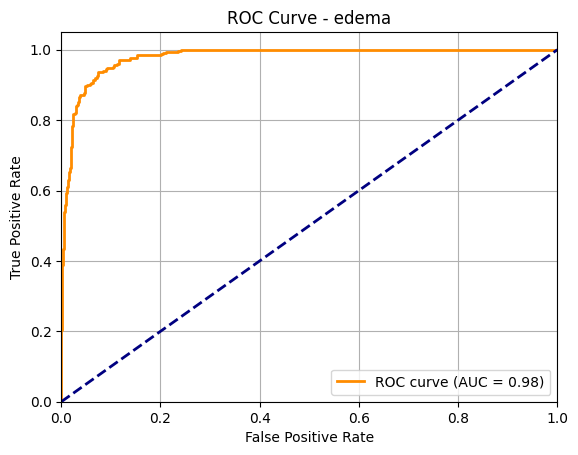

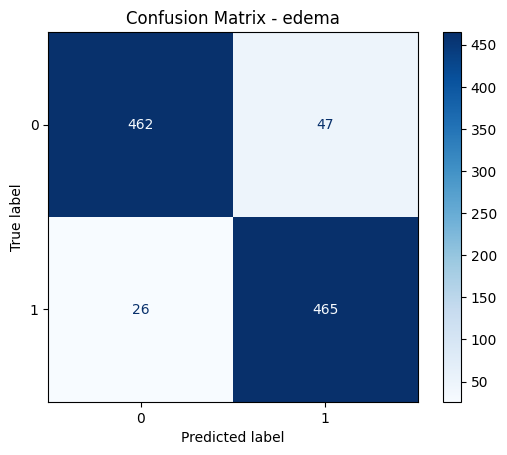

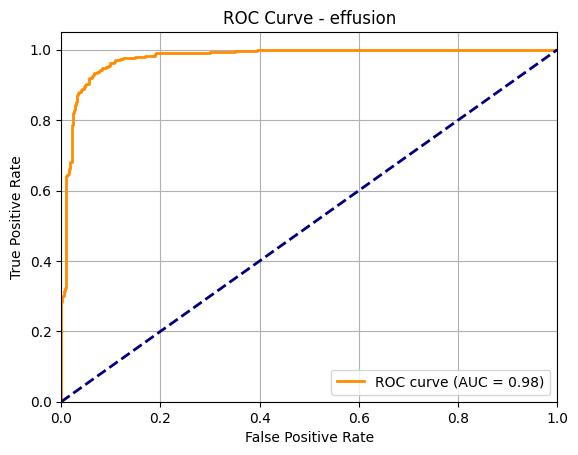

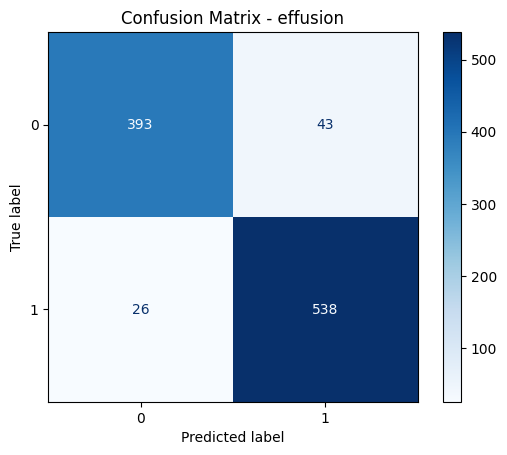

In [11]:
# Plot ROC curves
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

for i, name in enumerate(['edema', 'effusion']):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_probs[:, i])
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name}')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    # Plot confusion matrix
    cm = confusion_matrix(y_true[:, i], y_pred[:, i])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix - {name}')
    plt.grid(False)
    plt.show()
